In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())


['measurement', 'station']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


In [32]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Inches'].describe()
print(summary_statistics)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Inches, dtype: float64


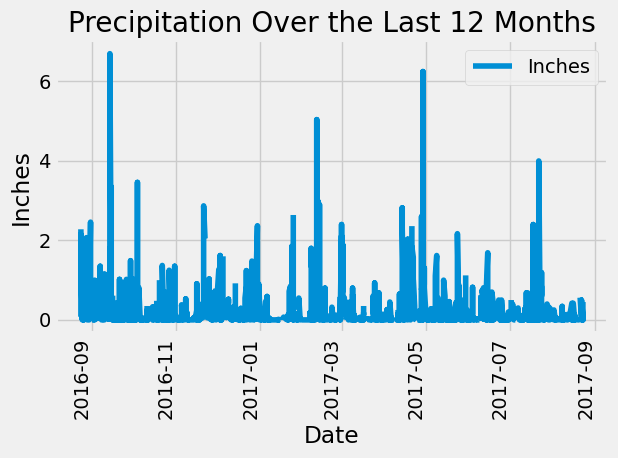

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Inches'])

# Sort the dataframe by date
df['Date'] = pd.to_datetime(df['Date'])  
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data  
df.set_index('Date', inplace=True)  # Set the Date as the index
df.plot(y='Inches', kind='line')  
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Over the Last 12 Months')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [40]:
print(one_year_ago)

2016-08-23 00:00:00


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).distinct().scalar()
total_stations

9

In [36]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Measurement.station,
    func.count(Measurement.id).label('observation_count')
).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()

for station, count in most_active_stations:
    print(f'Station: {station}, Observation Count: {count}')

Station: USC00519281, Observation Count: 2772
Station: USC00519397, Observation Count: 2724
Station: USC00513117, Observation Count: 2709
Station: USC00519523, Observation Count: 2669
Station: USC00516128, Observation Count: 2612
Station: USC00514830, Observation Count: 2202
Station: USC00511918, Observation Count: 1979
Station: USC00517948, Observation Count: 1372
Station: USC00518838, Observation Count: 511


In [37]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = 'USC00519281'
temperature_stats = session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp')
).filter(Measurement.station == most_active_station_id).all()
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f'Lowest Temperature: {min_temp}')
print(f'Highest Temperature: {max_temp}')
print(f'Average Temperature: {avg_temp}')

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


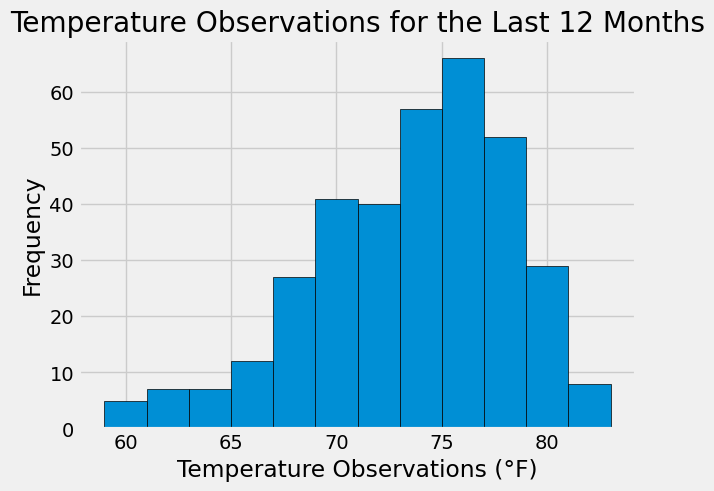

In [38]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
df_tobs = pd.DataFrame(tobs_data, columns=['TOBS'])
plt.hist(df_tobs['TOBS'], bins=12, edgecolor='black')
plt.xlabel('Temperature Observations (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Last 12 Months')
plt.show()

# Close Session

In [39]:
# Close Session
session.close()
